Debug Mode

In [15]:
debug = True
# debug = False

In [16]:
if debug: 
    '''choose test image''' # options: desk, desk2, guy, hand, hand2, backpack, car interior, car dashboard, street, garden, garden2, dog, guitar, house, motorbike, school, pottedplant, sheep, sofa, train, tvmonitor
    test_name = 'desk'
    # test_name = 'desk' 
    # test_name = 'hand'

Setup

In [17]:
# viz_res = [640, 480]
viz_res = tuple([400, 300])
# window_size = [1400, 800]
window_size = [1400, 1100]

Imports

In [18]:
'''generic'''
import numpy as np
import matplotlib.pyplot as plt
'''computer vision'''
import cv2
'''machine learning'''
# import torch
import mediapipe as mp
import onnxruntime as ort
'''user interface'''
import dearpygui.dearpygui as dpg
'''network'''
import re
import json
from io import BytesIO

Helpers

In [19]:
def imdpg2(img):
    return img.astype(np.float32)/255

def rgba(img, mask=None):
    if mask is None: mask = np.zeros(img.shape[:2])+255 # white mask
    rgba = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA) # convert to rgba
    rgba[:, :, 3] = np.interp(mask, (0, mask.max()), (0,255)) # rgba[:, :, 3] = mask # set alpha channel
    return rgba

Input Camera Stream

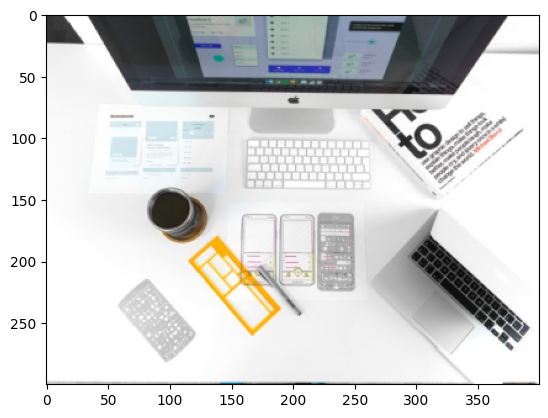

In [20]:
if debug: 
    img_raw = cv2.cvtColor(cv2.imread('./test_images/test_{}.jpg'.format(test_name)), cv2.COLOR_BGR2RGB)
else:
    cam = cv2.VideoCapture(0)
    _, img_raw = cam.read()

img = cv2.resize(img_raw, viz_res, interpolation=cv2.INTER_AREA)
img_rgba = rgba(img)
plt.imshow(img)

Hand Tracking (MediaPipe Hand)

In [21]:
# initialize model
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(model_complexity=0, max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)
# process
mp_results = hands.process(img)

In [22]:
# initialize visualization
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [23]:
def visualize_hands(mp_results, img):
    img = img.copy()
    landmarks = mp_results.multi_hand_landmarks
    if landmarks:
        for landmark in landmarks:
            mp_drawing.draw_landmarks(
                img, landmark, mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())
        # print(landmarks)
    return img

# plt.imshow(visualize_hands(mp_results, img))

Hand Gesture (MediaPipe )

Natural Language Interactivity

Cloud Server

Connection Status Check

Push Request

GUI

Initialize

In [ ]:
# setup DearPyGUI
dpg.create_context()
dpg.create_viewport(title='Real-Time Scene Analysis', width=window_size[0], height=window_size[1])
dpg.setup_dearpygui()
dpg.show_viewport()

: 

: 

Textures

In [ ]:
# TODO clean

In [ ]:
# texture registry
with dpg.texture_registry(show=False): # show=True
    dpg.add_raw_texture(width=img.shape[1], height=img.shape[0], default_value=imdpg2(img), format=dpg.mvFormat_Float_rgb, tag="original")
    dpg.add_raw_texture(width=img.shape[1], height=img.shape[0], default_value=imdpg2(img), format=dpg.mvFormat_Float_rgb, tag="edge")
    dpg.add_raw_texture(width=img.shape[1], height=img.shape[0], default_value=imdpg2(img), format=dpg.mvFormat_Float_rgb, tag="segmentation")
    dpg.add_raw_texture(width=img.shape[1], height=img.shape[0], default_value=imdpg2(img), format=dpg.mvFormat_Float_rgba, tag="masked_edge") # note rgbA
    # dpg.add_raw_texture(width=img.shape[1], height=img.shape[0], default_value=imdpg2(img), format=dpg.mvFormat_Float_rgb, tag="masked_edge") # fallback from RGBA for batch processing
    dpg.add_raw_texture(width=img.shape[1], height=img.shape[0], default_value=imdpg2(img), format=dpg.mvFormat_Float_rgb, tag="hand_tracking")
    dpg.add_raw_texture(width=img.shape[1], height=img.shape[0], default_value=imdpg2(img), format=dpg.mvFormat_Float_rgb, tag="virtual_fov")
    dpg.add_raw_texture(width=img.shape[1], height=img.shape[0], default_value=imdpg2(img), format=dpg.mvFormat_Float_rgb, tag="ofa")
    dpg.add_raw_texture(width=400, height=100, default_value=imdpg2(np.zeros(shape=[100,400,3])), format=dpg.mvFormat_Float_rgb, tag="tiplets")

# for initialization, just use original image to avoid errors. good. ... or not!

Windows

In [ ]:
# TODO clean

In [ ]:
# row 1
with dpg.window(label="Original", tag="original_window"):
    dpg.add_image("original")
dpg.set_item_pos("original_window", (0, 0))

with dpg.window(label="Edge", tag="edge_window"):
    dpg.add_image("edge")
dpg.set_item_pos("edge_window", (20+viz_res[0], 0))

# virtual FOV live-view window # column 3
with dpg.window(label="Virtual FOV", tag="virtual_fov_window"):
    dpg.add_image("virtual_fov")
    dpg.add_text("Zoom Factor: None", tag="zoom_factor_text")
dpg.set_item_pos("virtual_fov_window", ((20+viz_res[0])*2,0))


# row 2
with dpg.window(label="Segmentation", tag="segmentation_window"):
    dpg.add_image("segmentation")
dpg.set_item_pos("segmentation_window", (0, 40+viz_res[1]))

with dpg.window(label="Masked Edge", tag="masked_edge_window"):
    dpg.add_image("masked_edge")
dpg.set_item_pos("masked_edge_window", (20+viz_res[0], 40+viz_res[1]))

with dpg.window(label="Hand Tracking", tag="hand_tracking_window"):
    dpg.add_image("hand_tracking")
dpg.set_item_pos("hand_tracking_window", ((20+viz_res[0])*2, 40+viz_res[1]+22))


# row 3
# natural language input window
# with dpg.window(label="Language Input (Naive)", tag="naive_input_window", width=15+viz_res[0]):
#     with dpg.group(horizontal=True):
#         dpg.add_input_text(tag="naive_input")
#         dpg.add_button(label="Select", callback=select_object)
# dpg.set_item_pos("naive_input_window", (0, (40+viz_res[1])*2))
virtual_fov = np.zeros(shape=img.shape, dtype=np.uint8)
focus = None
# OFA output window (temporary) TODO combine with tracking visualization (paths)
# with dpg.window(label="Language Input", tag="language_input_window", width=15+viz_res[0]):
#     dpg.add_text("Task Selection:")
#     dpg.add_radio_button(items=['Object Finding', 'Image Captioning', 'Question Answering'], tag="ofa_task", default_value='Object Finding')
#     with dpg.group(horizontal=True):
#         dpg.add_input_text(tag="language_input")
#         dpg.add_button(label="Submit", callback=parse_language)
#     dpg.add_text("Note: For image captioning task, input text is ignored.", color=[127]*3)
#     # todo: add speech recognition button (possible because it's retained mode GUI)
# dpg.set_item_pos("language_input_window", (0, (40+viz_res[1])*2))

# with dpg.window(label="Language Output", tag="ofa_output_window"):
#     dpg.add_image("ofa")
#     dpg.add_text(tag="ofa_output", default_value="")
# dpg.set_item_pos("ofa_output_window", (20+viz_res[0], (40+viz_res[1])*2))


# with dpg.window(label="TipLets Output", tag="tiplets_output_window"):
#     dpg.add_image("tiplets")
#     dpg.add_text("Source of Vibration")
#     dpg.add_radio_button(items=['Masked Edge', 'Virtual FOV'], tag="source", default_value='Virtual FOV')

# dpg.set_item_pos("tiplets_output_window", ((20+viz_res[0])*2, (40+viz_res[1])*2+22))
# # colab diagnostics
# with dpg.window(label="Colab Webserver Connection Diagnostics", tag="diagnostics_window", width=15+viz_res[0]):
#     with dpg.group(horizontal=True):
#         dpg.add_input_text(tag="url_input", default_value=url)
#         dpg.add_button(label="Update URL", callback=update_url)
#     with dpg.group(horizontal=True):
#         dpg.add_text('???', tag="colab_status_text", color=[255,255,255])
#         dpg.add_button(label="Refresh Status", callback=update_status)

dpg.set_item_pos("diagnostics_window", ((20+viz_res[0])*2, (40+viz_res[1])*2+230))



# misc.
# colormap -- maybe useful for even edge vizualization.
# colormap = plt.get_cmap()
# colormap = plt.get_cmap('inferno')

NameError: name 'parse_language' is not defined

Loop

In [ ]:
%%prun -s cumulative -q -l 10 -T mainloop_profile.txt -D mainloop_profile.pstat 
# profile cell & save to "mainloop3.txt", "mainloop3.pstat" for run-time analysis 
# source: https://ipython-books.github.io/42-profiling-your-code-easily-with-cprofile-and-ipython/


c = 0; start_time = time.time()

while dpg.is_dearpygui_running():
    
    """Camera Input"""
    if debug: pass
    else: 
        _, raw = cam.read(); raw = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
        img = cv2.resize(raw, viz_res, interpolation=cv2.INTER_AREA)

    """Canny Edge Detection (OpenCV)"""
    # edge = canny(img)

    """Deep Learning Based Edge Detection (PiDiNet)"""
    # edge = (pidinet(img)*255).astype(np.uint8)
    # edge = cv2.cvtColor(edge, cv2.COLOR_GRAY2RGB)
    """(via ONNX)"""
    edge = (pidinet_onnx(img)*255).astype(np.uint8)
    edge = cv2.cvtColor(edge, cv2.COLOR_GRAY2RGB)
    
    """Semantic Segmentation (Yolact Edge)"""
    if debug: pass
    else: 
        frame = torch.from_numpy(img).cuda().float(); batch = FastBaseTransform()(frame.unsqueeze(0)) # 만약 오작동시 BGR로 바꿔 테스트.
        blank = torch.from_numpy(np.zeros(shape=img.shape)).cuda().float()
        # blank = torch.from_numpy(np.zeros(shape=img.shape)).float().cuda() # any significant speed differences?

        preds = net(batch, extras=extras)["pred_outs"]; dets = preds[0]

        seg_overlay, seg_mask = viz_and_mask(preds, frame)

    """Masked Edge"""
    # masked_edge = rgba(edge, seg_mask)
    masked_edge = rgba(edge, dilate_mask3(seg_mask)) 

    """Hand Tracking"""
    mp_results = hands.process(img)
    hand_tracking = visualize_hands(mp_results, img)

    """Natural Language Interaction"""
    # implemented as callback functions. Refer to Section A1 (i.e., parse_language(), call_ofa(), update_url())

    """Virtual FOV"""
    # TODO wrap this into a function. # will also make it easier to debug (outside of DPG)
    if focus is not None:
        # virtual_fov[focus[1]:focus[3], focus[0]:focus[2]] = masked_edge[:,:,:3][focus[1]:focus[3], focus[0]:focus[2]]
        virtual_fov[focus[1]:focus[3], focus[0]:focus[2]] = blend(masked_edge)[focus[1]:focus[3], focus[0]:focus[2]]
        # print(virtual_fov.shape); print(img.shape)
        margin = 10
        zoom_factor = min((img.shape[0]-margin)/(focus[3]-focus[1]), (img.shape[1]-margin)/(focus[2]-focus[0]))
        focus_center = [(focus[3]+focus[1])//2, (focus[2]+focus[0])//2] # (y,x)
        # virtual_fov = zoom_image(virtual_fov, zoom_factor, focus_center)
        virtual_fov = zoom_image(move_center(virtual_fov, focus_center), zoom_factor) 

        dpg.set_value('zoom_factor_text', "Zoom Factor: {}".format(round(zoom_factor, 2)))
        
        # virtual_fov[focus[1]:focus[3], focus[0]:focus[2]] = 255 # white-mask virtual box
        # masked_edge[focus[1]:focus[3], focus[0]:focus[2]][:3]
    else: pass


    """TipLets Output"""
    tip_pos, tip_dir = tip_info(mp_results, img)
    tiplets = draw_tiplet_outputs(outputs)

    # Fingertip Visualization
    if dpg.get_value('source') == 'Masked Edge': pass
    elif dpg.get_value('source') == 'Virtual FOV':
        try:
            # virtual_fov = visualize_tips(tip_pos, tip_dir, virtual_fov) # finger marker only
            virtual_fov = visualize_tiplets3(*tip_info(mp_results, img), virtual_fov) # tiplets only (best)
            # virtual_fov = visualize_tiplets(*tip_info(mp_results, img), visualize_tips(*tip_info(mp_results, img), virtual_fov)) # both (eh)
        except Exception: pass # no hand detected

    """Object Tracking""" # TODO wrap into a function
    # boxes, scores, class_ids = yolov7_detector(img)
    # dets = np.concatenate((boxes, scores[:,np.newaxis]),axis=1)

    # # update SORT
    # track_bbs_ids = mot_tracker.update(dets)
    # track_bbs_ids.astype(np.int32)

    # draw path visualizations on OFA output window (leave original and overwrite on top)
    
    # 음성인식 추가 (via Colab)

    # TipLets, WristLets output computation.


    """Push Textures"""
    dpg.set_value("original",      imdpg2(img))
    dpg.set_value("edge",          imdpg2(edge)) 
    dpg.set_value("segmentation",  imdpg2(seg_overlay))
    dpg.set_value("masked_edge",   imdpg2(masked_edge)) # NOTE can either use rgb & blend, or rgba & no blend.
    dpg.set_value("virtual_fov",   imdpg2(virtual_fov))
    dpg.set_value("hand_tracking", imdpg2(hand_tracking))
    dpg.set_value("tiplets",       imdpg2(tiplets))
    dpg.set_value("ofa",           imdpg2(ofa))


    """Push Frame"""
    dpg.render_dearpygui_frame()
    c += 1

end_time = time.time()
time_delta = end_time - start_time
dpg.destroy_context()

print("Frames Per Second:", round(c/time_delta, 2))
